#   NGC 4321 examples of processing Hershel data


Data can be downloaded via http://archives.esac.esa.int/hsa/whsa (**HSA**)
you will pick an Observation ID (OID). Apart from a top level convenience directory name, the extracted tar file will typically have a multi-level directory structure. We will be mostly (if not all) use the **level2** products, e.g.

    1342223728/level2/HPS3DB/herschel.pacs.signal.PacsCube/hpacs1342223728_20hps3dbs_08_1469459187154.fits.gz 

For this galaxy there is also KINGFISH data available, but these are differently (better) organized, as they have gone through additional processing steps.

We will only be using PACS and SPIRE, and ignore the single pixel HIFI data (which covers roughly the same spectral range as SPIRE, but with very high spectral resolution)

![image](pacs+spire.png)

# Oberving Modes

These are the HSA observing modes, and which OID's are discussed below

    
    SpirePacsParallel       1342198147 (comes in a separate PACS and SPIRE oid)
    PacsLineSpec            1342223728 (the first of the 9 Kingfish) 1342199746 and 1342199747 via rguesten
    SpireSpectroPoint       1342247572
    PacsPhoto               1342212438
    SpirePhotoLargeScan     
    HiFi.....               n/a here



In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from astropy.io import fits
import aplpy

Below are some simple access functions, for more flexible processing a class based system would be ideal.

In [2]:
def get_radec(ffile):
    """
    Return a list of (ra,dec) of the pointing in this bintable
    """
    print("get_radec:",ffile)
    hdu = fits.open(ffile)
    print(len(hdu),'luns')
    hdr = hdu[1].header
    dat = hdu[1].data
    if hdr['EXTNAME'] != 'spectrum2d':
        print("Bad EXTNAME = ",hdr['EXTNAME'])
        return None
    ra = dat['longitude']
    dec = dat['latitude']
    #waves = hdu[1].data['wave']
    #fluxs = hdu[1].data['flux']
    return (ra,dec)

def get_image(ffile):
    """
    return the HDU, Header,Data of an image
    """
    print('get_image:',ffile)
    hdu = fits.open(ffile)
    print(len(hdu),'luns')
    imh = hdu[1].header
    imd = hdu[1].data
    if imh['EXTNAME'] != 'image':
        print("Bad EXTNAME = ",hdr['EXTNAME'])
        return None
    print(imd.shape)
    return (hdu[1],imh,imd)

# SPIRE oid = 1342247572

There is only one **SpireSpectroPoint** for NGC 4321. On level2 we find the following datasets:

    HR_SLW_cube                       8 x 7 x 1906
    HR_SLW_cube_apod
    HR_SLW_cube_convol
    HR_SLW_cube_convol_apod
    HR_SLW_spectrum2d                 17 x 76   (76 pointings of 1906 chans)
    HR_SLW_spectrum2d_apod
    HR_SSW_cube                       12 x 13 x 2082
    HR_SSW_cube_apod
    HR_SSW_cube_convol
    HR_SSW_cube_convol_apod
    HR_SSW_spectrum2d                 18 x 140  (140 pointings of 2082 chans)
    HR_SSW_spectrum2d_apod
    
    


In [3]:
slw_spectrum2d = '1342247572/level2/HR_SLW_spectrum2d/hspirespectrometer1342247572_spg_SLW_HR_20spc_1461672208029.fits.gz'
(ra1,dec1) = get_radec(slw_spectrum2d)

ssw_spectrum2d = '1342247572/level2/HR_SSW_spectrum2d/hspirespectrometer1342247572_spg_SSW_HR_20spc_1461672211449.fits.gz'
(ra2,dec2) = get_radec(ssw_spectrum2d)

get_radec: 1342247572/level2/HR_SLW_spectrum2d/hspirespectrometer1342247572_spg_SLW_HR_20spc_1461672208029.fits.gz
2 luns
get_radec: 1342247572/level2/HR_SSW_spectrum2d/hspirespectrometer1342247572_spg_SSW_HR_20spc_1461672211449.fits.gz
2 luns


In [4]:
ssw_cube = '1342247572/level2/HR_SSW_cube/hspirespectrometer1342247572_spg_SSW_HR_20ssc_1461672208855.fits.gz'
slw_cube = '1342247572/level2/HR_SLW_cube/hspirespectrometer1342247572_spg_SLW_HR_20ssc_1461672206639.fits.gz'

In [5]:
(hdu1,h1,d1) = get_image(slw_cube)

get_image: 1342247572/level2/HR_SLW_cube/hspirespectrometer1342247572_spg_SLW_HR_20ssc_1461672206639.fits.gz
5 luns
(1905, 7, 8)


INFO: Auto-setting vmin to -3.323e-19 [aplpy.core]
INFO: Auto-setting vmax to  9.405e-19 [aplpy.core]


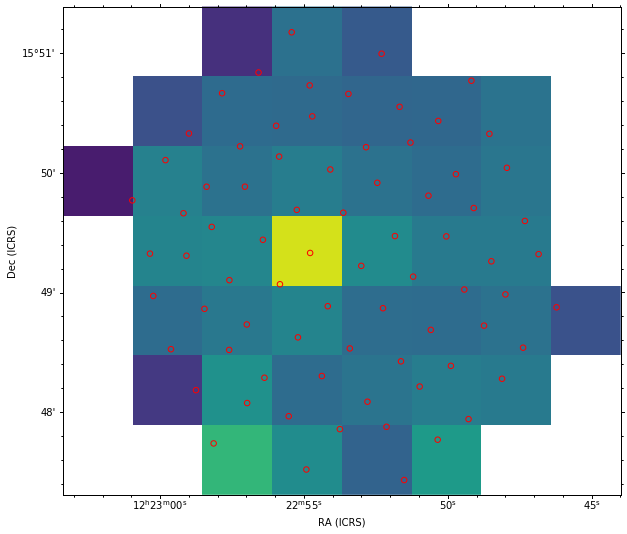

In [6]:
gc = aplpy.FITSFigure(hdu1,slices=[805])
gc.show_colorscale()
gc.show_markers(ra1,dec1)

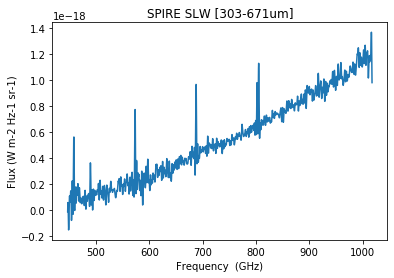

In [7]:
xpos = 3
ypos = 3
sp1 = d1[:,ypos,xpos]
ch1 = np.arange(len(sp1))
ch1 = (ch1+1-h1['CRPIX3'])*h1['CDELT3']+h1['CRVAL3']
plt.plot(ch1,sp1)
plt.xlabel("%s  (%s)" %  (h1['CTYPE3'],h1['CUNIT3']))
plt.ylabel("Flux (%s)" % h1['BUNIT'])
# or zoom in around a line, the numbers here are channel numbers still
#plt.xlim(0,200)
#plt.xlim(700,900)
#plt.xlim(350,500)
#plt.xlim(1100,1300)
#plt.xlim(1750,1900)
#plt.xlim(750,820)
plt.title("SPIRE SLW [303-671um]");

In [8]:
(hdu2,h2,d2) = get_image(ssw_cube)

get_image: 1342247572/level2/HR_SSW_cube/hspirespectrometer1342247572_spg_SSW_HR_20ssc_1461672208855.fits.gz
5 luns
(2082, 13, 12)


INFO: Auto-setting vmin to -4.480e-19 [aplpy.core]
INFO: Auto-setting vmax to  4.310e-18 [aplpy.core]


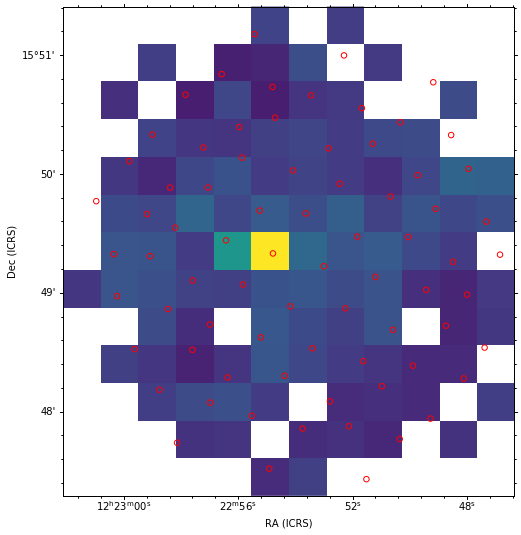

In [9]:
gc = aplpy.FITSFigure(hdu2,slices=[805])
gc.show_colorscale()
gc.show_markers(ra1,dec1)

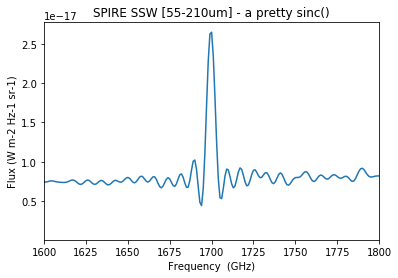

In [10]:
xpos = 5
ypos = 6
sp2 = d2[:,ypos,xpos]
ch2 = np.arange(len(sp2))
#ch2 = (ch2+1-h2['CRPIX3'])*h2['CDELT3'] + h2['CRVAL3']
plt.plot(ch2,sp2)
plt.xlabel("%s  (%s)" %  (h2['CTYPE3'],h2['CUNIT3']))
plt.ylabel("Flux (%s)" % h2['BUNIT'])
plt.title("SPIRE SSW [55-210um] - a pretty sinc()")
#plt.title(slw_cube)
# or zoom in around a line, and see a pretty sinc
plt.xlim(1600,1800);

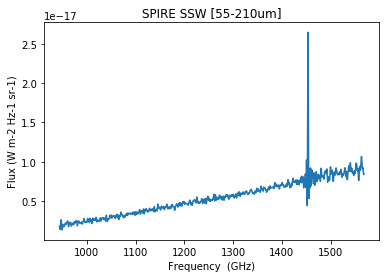

In [11]:
xpos = 5
ypos = 6
sp2 = d2[:,ypos,xpos]
ch2 = np.arange(len(sp2))
ch2 = (ch2+1-h2['CRPIX3'])*h2['CDELT3'] + h2['CRVAL3']
plt.plot(ch2,sp2)
plt.xlabel("%s  (%s)" %  (h2['CTYPE3'],h2['CUNIT3']))
plt.ylabel("Flux (%s)" % h2['BUNIT'])
plt.title("SPIRE SSW [55-210um]");

# PACS oid = 1342212438

This is a **PacsPhoto** , **B** refers to Blue (55-105), **R** refers to Red (105-210)

    HPPPMAPB       6241 x 6521
    HPPPMAPR       6242 x 6522

We will overlay the (ra,dec) positions from the SpireSpectroPoint on these images.


In [12]:
hpppmapb = '1342212438/level2/HPPPMAPB/hpacs1342212438_20hpppmapb_00_1469367980473.fits.gz'
hpppmapr = '1342212438/level2/HPPPMAPR/hpacs1342212438_20hpppmapr_00_1469367982271.fits.gz'

In [13]:
(hdu1,h1,d1) = get_image(hpppmapb)
print(d1.shape,d1.min(),d1.max(),d1.mean(),d1.std())

get_image: 1342212438/level2/HPPPMAPB/hpacs1342212438_20hpppmapb_00_1469367980473.fits.gz
10 luns
(854, 763)
(854, 763) -0.020666764339736833 0.11612247185016154 6.300825898138048e-05 0.0012960774092399025


INFO: Auto-setting vmin to -3.936e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.872e-03 [aplpy.core]


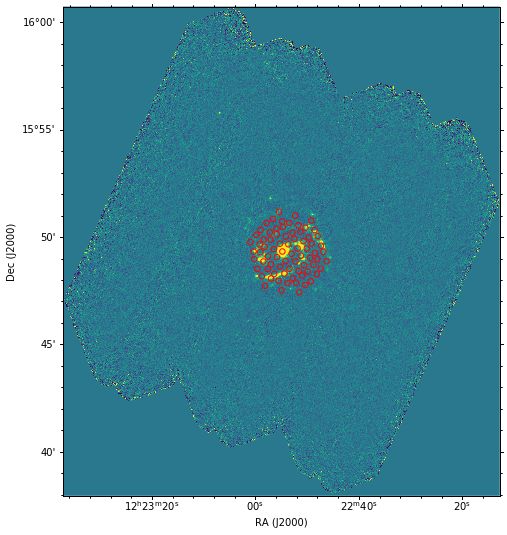

In [14]:
gc = aplpy.FITSFigure(hdu1)
gc.show_colorscale()
gc.show_markers(ra1,dec1)

In [15]:
(hdu2,h2,d2) = get_image(hpppmapr)

get_image: 1342212438/level2/HPPPMAPR/hpacs1342212438_20hpppmapr_00_1469367982271.fits.gz
10 luns
(428, 384)


INFO: Auto-setting vmin to -1.010e-02 [aplpy.core]
INFO: Auto-setting vmax to  3.787e-02 [aplpy.core]


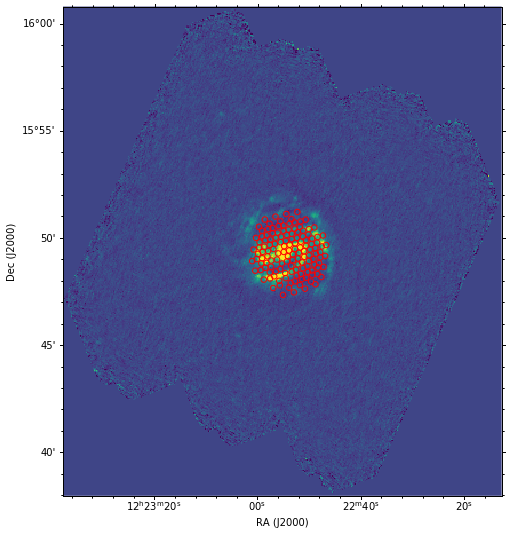

In [16]:
gc = aplpy.FITSFigure(hdu2)
gc.show_colorscale()
gc.show_markers(ra2,dec2)

# PACS oid = 1342223728

This is a **PacsLineSpec** , **B** refers to Blue (55-105), **R** refers to Red (105-210)

This is by far the more complex type of datasets.  Here is a summary, with more to come.
   
    
    HPS3DB/herschel.pacs.signal.PacsCube                         00..11   5 x  5 x 24000   flux,wave,ra,dec    
    HPS3DDR/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  32 x 32 x 160     image               
    HPS3DEQDR/herschel.ia.dataset.spectrum.SpectralSimpleCube    00..01  34 x 32 x 458     image               
    HPS3DEQIB/herschel.ia.dataset.spectrum.SpectralSimpleCube    00..01  25 x 25 x 769     image,              
    HPS3DIB/herschel.ia.dataset.spectrum.SpectralSimpleCube
    HPS3DPB/herschel.ia.dataset.spectrum.SpectralSimpleCube
    HPS3DPR/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  34 x 32 x 160     image               
    HPS3DRB/herschel.pacs.signal.PacsRebinnedCube                00..08   5 x  5 x 268     image,ra,dec        
    HPS3DR/herschel.pacs.signal.PacsCube                         00..11   5 x  5 x 24000   flux,wave,ra,dec
    HPS3DRR/herschel.pacs.signal.PacsRebinnedCube                00..07   5 x  5 x 160     image,ra,dec
    HPSTBRB/herschel.pacs.signal.PacsSpecTable                   00..01       11 x 26800   Spectra [...]
    HPSTBRR/herschel.pacs.signal.PacsSpecTable                   00..01       11 x 16000 
    

In [17]:
pacsCube = '1342223728/level2/HPS3DB/herschel.pacs.signal.PacsCube/hpacs1342223728_20hps3dbs_00_1469459160764.fits.gz'

hdu = fits.open(pacsCube)
flux = hdu[1].data
wave = hdu[2].data
ra = hdu[3].data
dec = hdu[4].data
print(wave.min(),wave.max())
#print(flux.min(),flux.max())


88.23754384270084 89.44033831776495


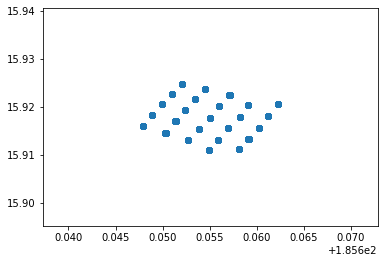

In [18]:
ras = ra.ravel()[:1000]
decs = dec.ravel()[:1000]
plt.scatter(ras,decs)

In [19]:
hps3ddr = '1342223728/level2/HPS3DDR/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3ddrs_00_1469459197218.fits.gz'
(hdu3,h3,d3) = get_image(hps3ddr)

get_image: 1342223728/level2/HPS3DDR/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3ddrs_00_1469459197218.fits.gz
11 luns
(160, 32, 34)


In [20]:
#gc = aplpy.FITSFigure(hdu3,slices=[80])
#gc.show_colorscale()
#gc.show_markers(ra2,dec2)

# SpirePacsParallel

     1342198147/level2/HPPPMAPB/hpacs1342198147_20hpppmapb_00_1469312216448.fits.gz       6241 x 6521
     1342198147/level2/HPPPMAPR/hpacs1342198147_20hpppmapr_00_1469312277296.fits.gz       6242 x 6522


# AstroQuery


See also    https://astroquery.readthedocs.io/en/latest/irsa/irsa.html

    >>> from astroquery.irsa import Irsa
    >>> Irsa.print_catalogs()

    z0mgsdr1index                   z0MGS DR1 Index
    z0mgsdr1simple                  z0MGS DR1 7.5 arcsec Simple Index
    
    ppsc_70                         PACS Point Source Catalog: 70 microns
    ppsc_100                        PACS Point Source Catalog: 100 microns
    ppsc_160                        PACS Point Source Catalog: 160 microns
    ppsc_extsl                      PACS Point Source Catalog: Extended Source List
    ppsc_obstbl                     PACS Point Source Catalog: Observation Table
    ppsc_rejsl                      PACS Point Source Catalog: Rejected Source List
    spsc250                         SPIRE Point Source Catalog: 250 microns
    spsc350                         SPIRE Point Source Catalog: 350 microns
    spsc500                         SPIRE Point Source Catalog: 500 microns
    spscxid                         SPIRE Point Source Catalog Cross-Reference Matrix


In [21]:
from astroquery.irsa import Irsa
from astropy import coordinates
import astropy.units as u    

In [22]:
t70 = Irsa.query_region("ngc4321",catalog="ppsc_70", spatial="Cone",radius=4 * u.arcmin)    

In [23]:
print(t70)

           name            band     ra     ... ssomapflag    dist      angle   
                                   deg     ...              arcsec      deg    
-------------------------- ---- ---------- ... ---------- ---------- ----------
HPPSC070A_J122251.3+154933 blue 185.714066 ...          f  51.890385 286.105027
HPPSC070A_J122254.6+154819 blue 185.727568 ...          f  59.827221 182.959848
HPPSC070A_J122258.8+154937 blue 185.745090 ...          f   60.46935  72.271844
HPPSC070A_J122257.0+154809 blue 185.737772 ...          f  76.623529 155.103199
HPPSC070A_J122300.2+154921 blue 185.750992 ...          f  78.091491  87.973581
HPPSC070A_J122257.4+154809 blue 185.739407 ...          f  79.572565 151.540068
HPPSC070A_J122248.7+155000 blue 185.703166 ...          f  97.121465 295.578113
HPPSC070A_J122259.8+154812 blue 185.749443 ...          f  98.811773 132.644404
HPPSC070A_J122248.7+155014 blue 185.703088 ...          f 103.907117 302.255961
HPPSC070A_J122253.2+154736 blue 185.7219

In [24]:
t500 = Irsa.query_region("ngc4321",catalog="spsc500", spatial="Cone",radius=4 * u.arcmin)  

In [25]:
print(t500)

          spscid          det    ra    ...       q3ctile         dist    angle  
                                deg    ...                      arcsec    deg   
------------------------- --- -------- ... ------------------- ------- ---------
HSPSC500A_J1222.91+1549.3 PLW 185.7288 ... 4361459162178125823 1.55012 49.437796


# pySpecKit

It's possible that this package can help displaying and fitting spectra.  TBD.
